# HW1 Counting words and phrases

## Yimin Li liym15@uchicago.edu

In [61]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas as pd#gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls
import re
import nltk

# comp-linguistics
import spacy
import en_core_web_sm

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

### Merge dataset and clean data

In this exercise, we use two dataframes from Spotify, one is the lyrics of these songs and the other is some key features of the songs provided by Spotify. 

In [26]:
# First, we merge these two datasets.

with open('lyrics_file.json') as f:
    dict_ = json.load(f)
df_1 = pd.DataFrame.from_dict([dict_])
df_1 = df_1.T
df_1.columns = ['Lyrics']
df_1['title'] = df_1.index
df_1.index = range(df_1.shape[0])
df_1.head()

,Lyrics,title
0,\n\n[Intro]\nHeyy\nHeeey\nHeey\n\n[Verse 1]\nY...,"Hey, Soul Sister"
1,\n\n[Chorus: Rihanna]\nJust gonna stand there ...,Love The Way You Lie
2,\n\n[Verse 1]\nWake up in the morning feelin' ...,TiK ToK
3,\n\n[Intro]\nOh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-...,Bad Romance
4,"\n\n[Verse 1]\nOh, her eyes, her eyes\nMake th...",Just the Way You Are


In [27]:
df_2 = pd.read_csv("top10s.csv", engine="python", index_col='index')
df_2.head()

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
index,,,,,,,,,,,,,,
1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83.0
2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82.0
3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80.0
4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79.0
5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78.0


In [31]:
df = pd.merge(df_1, df_2, on='title')
df.head()

,Lyrics,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,\n\n[Intro]\nHeyy\nHeeey\nHeey\n\n[Verse 1]\nY...,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83.0
1,\n\n[Chorus: Rihanna]\nJust gonna stand there ...,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82.0
2,\n\n[Verse 1]\nWake up in the morning feelin' ...,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80.0
3,\n\n[Intro]\nOh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-...,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79.0
4,"\n\n[Verse 1]\nOh, her eyes, her eyes\nMake th...",Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78.0


### Spacy

In [53]:
# Then we turn the text into a ntlk object and conduct exploratory analysis
nlp = en_core_web_sm.load() # I always get an error when using spacy, and it says this has same function as spacy
df['tokenized'] = None

In [54]:
# helper function retrieved from the lab
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [55]:
df_tokens = []
for index in range(df.shape[0]):
    row = df['Lyrics'][index]
    row = re.sub(r'\[.*?\]', '', row) # remove comments in the lyrics
    df['tokenized'][index] = word_tokenize(row)
    df_tokens += word_tokenize(row)
len(df_tokens)

C:\Users\qmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


228142

In [56]:
# Counting words borrowed from materials
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)


In [60]:
df_words_count = wordCounter(df_tokens)
df_words_count.sort_values('count', ascending=False, inplace=True)
df_words_count.head(10)

,word,count
15,i,12630
20,you,9795
7,the,6357
122,it,4641
70,me,4262
377,oh,4116
59,to,3595
18,n't,3517
21,and,3509
61,a,3312


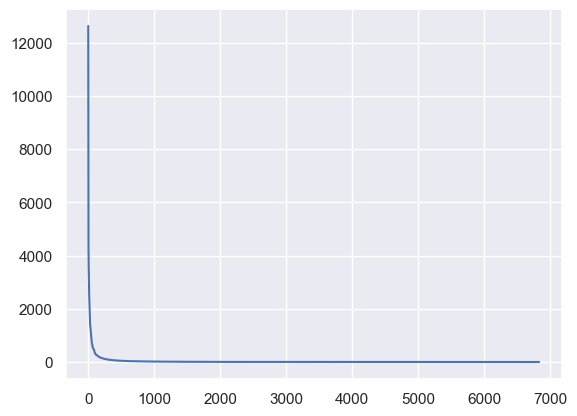

In [82]:
# Then we plot the picture based on df_words_count
fig = plt.figure()
plt.plot(range(len(df_words_count)), df_words_count['count'])
plt.show()

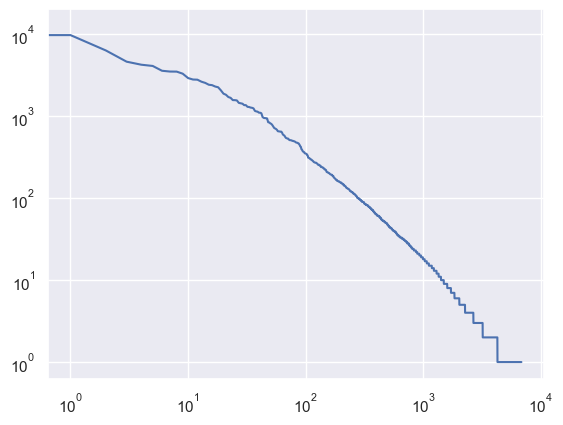

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(df_words_count)), df_words_count['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

### NLTK

In [85]:
# Then we use the nltk
text = nltk.Text(df_tokens)
index = nltk.text.ConcordanceIndex(text)
index.print_concordance('love')

Displaying 25 of 1795 matches:
ou gave my life direction A game show love connection We ca n't deny I 'm so obs
 cry Well that 's all right because I love the way you lie I love the way you li
ight because I love the way you lie I love the way you lie I ca n't tell you wha
t 's like I 'm in flight High off her love drunk from her hate It 's like I 'm h
te It 's like I 'm huffin paint and I love her the more I suffer I suffocate And
scitates Me she fuckin hates me and I love it Wait Where you going I 'm leaving 
 cry Well that 's all right because I love the way you lie I love the way you li
ight because I love the way you lie I love the way you lie I love the way you li
 way you lie I love the way you lie I love the way you lie You ever love somebod
u lie I love the way you lie You ever love somebody so much you can barely breat
 cry Well that 's all right because I love the way you lie I love the way you li
ight because I love the way you lie I love the way you lie I love the way you 

In [86]:
text.count('love')

1795

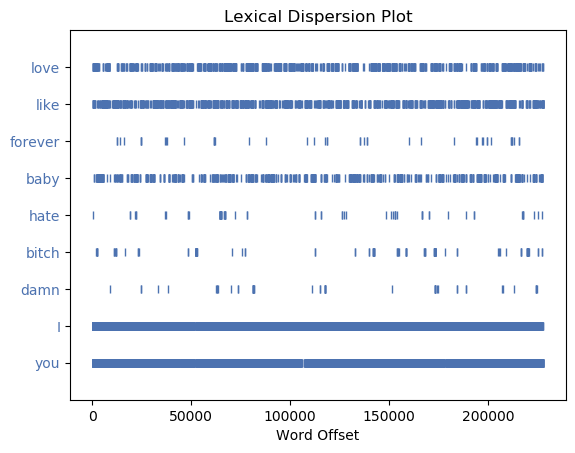

In [87]:
# Display results of "love", 'hate'
ls_keyword = ['love', 'like', 'forever', 'baby', 'hate', 'bitch', 'damn', 'I', 'you']
sns.reset_orig() #Seaborn messes with this plot, disabling it
text.dispersion_plot(ls_keyword)
sns.set() #Re-enabling seaborn

In [88]:
# Then we explore how many tokenized per each song
df['word_counts'] = df['tokenized'].apply(lambda x: len(x))
df.head()

,Lyrics,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,tokenized,word_counts
0,\n\n[Intro]\nHeyy\nHeeey\nHeey\n\n[Verse 1]\nY...,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83.0,"[Heyy, Heeey, Heey, Your, lipstick, stains, On...",317
1,\n\n[Chorus: Rihanna]\nJust gonna stand there ...,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82.0,"[Just, gon, na, stand, there, and, watch, me, ...",801
2,\n\n[Verse 1]\nWake up in the morning feelin' ...,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80.0,"[Wake, up, in, the, morning, feelin, like, P.,...",513
3,\n\n[Intro]\nOh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-...,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79.0,"[Oh, oh, oh, oh, oh, oh, oh, oh, oh, oh, oh, o...",663
4,"\n\n[Verse 1]\nOh, her eyes, her eyes\nMake th...",Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78.0,"[Oh, her, eyes, her, eyes, Make, the, stars, l...",313


## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [90]:
# Count words and creat word pair
countsDict = {}
for word in df['tokenized'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_pair = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts_pair[:20]

[('I', 12538),
 ('you', 8231),
 ('the', 5915),
 ('me', 4218),
 ('it', 4030),
 ("n't", 3517),
 ('to', 3430),
 ('a', 3177),
 ('oh', 2995),
 ('my', 2711),
 ("'m", 2643),
 ("'s", 2555),
 ('do', 2303),
 ('your', 2270),
 ('on', 2194),
 ('that', 2159),
 ('in', 2122),
 ('and', 1986),
 ('we', 1923),
 ('love', 1795)]

In [92]:
# Stop Words
ls_stop_words = []
for word, count in word_counts_pair:
    if word == 'love': # Choose love as the stop words cut off
        break
    else:
        ls_stop_words.append(word)
ls_stop_words

['I',
 'you',
 'the',
 'me',
 'it',
 "n't",
 'to',
 'a',
 'oh',
 'my',
 "'m",
 "'s",
 'do',
 'your',
 'on',
 'that',
 'in',
 'and',
 'we']

### Normalized

In [93]:
# normalized tokens
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [94]:
df['normalized_tokens'] = df['tokenized'].apply(lambda x: normalizeTokens(x, extra_stop=ls_stop_words))
df['normalized_tokens_count'] = df['normalized_tokens'].apply(lambda x: len(x))
df.head()

,Lyrics,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,tokenized,word_counts,normalized_tokens,normalized_tokens_count
0,\n\n[Intro]\nHeyy\nHeeey\nHeey\n\n[Verse 1]\nY...,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83.0,"[Heyy, Heeey, Heey, Your, lipstick, stains, On...",317,"[heyy, heeey, heey, lipstick, stain, lobe, lef...",149
1,\n\n[Chorus: Rihanna]\nJust gonna stand there ...,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82.0,"[Just, gon, na, stand, there, and, watch, me, ...",801,"[gon, na, stand, watch, burn, right, like, way...",314
2,\n\n[Verse 1]\nWake up in the morning feelin' ...,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80.0,"[Wake, up, in, the, morning, feelin, like, P.,...",513,"[wake, morning, feelin, like, p., diddy, hey, ...",242
3,\n\n[Intro]\nOh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-...,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79.0,"[Oh, oh, oh, oh, oh, oh, oh, oh, oh, oh, oh, o...",663,"[catch, bad, romance, catch, bad, romance, ra,...",321
4,"\n\n[Verse 1]\nOh, her eyes, her eyes\nMake th...",Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78.0,"[Oh, her, eyes, her, eyes, Make, the, stars, l...",313,"[eye, eye, star, look, like, shinin, hair, hai...",100


### Conditional Frequency Distribution

In [96]:
# Conditional Frequency Distribution
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df['normalized_tokens'].sum()))

print(whcfdist.N())

93289


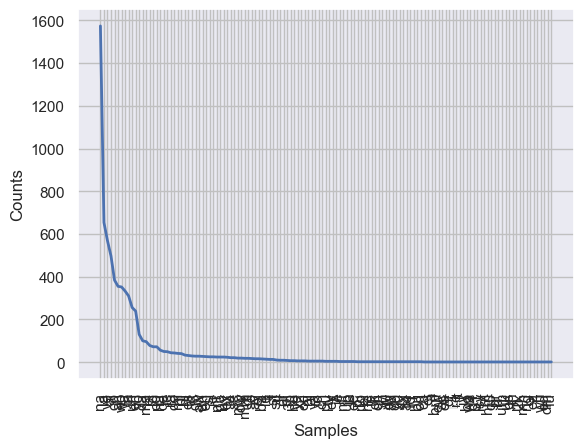

In [99]:
whcfdist[2].plot()

### Conditional Probability Distribution

In [101]:
# Conditional Probability Distribution
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

print(whcpdist[5].max())
print(whcpdist[5].prob(whcpdist[5].max()))

wanna
0.04711675748127859


In [102]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [104]:
df['normalized_pos'] = [spacy_pos(t) for t in df['Lyrics']]
df.head()

,Lyrics,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,tokenized,word_counts,normalized_tokens,normalized_tokens_count,normalized_pos
0,\n\n[Intro]\nHeyy\nHeeey\nHeey\n\n[Verse 1]\nY...,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83.0,"[Heyy, Heeey, Heey, Your, lipstick, stains, On...",317,"[heyy, heeey, heey, lipstick, stain, lobe, lef...",149,"[(\n\n, _SP), ([, -LRB-), (intro, NNP), (], -R..."
1,\n\n[Chorus: Rihanna]\nJust gonna stand there ...,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82.0,"[Just, gon, na, stand, there, and, watch, me, ...",801,"[gon, na, stand, watch, burn, right, like, way...",314,"[(\n\n, _SP), ([, -LRB-), (chorus, NN), (:, :)..."
2,\n\n[Verse 1]\nWake up in the morning feelin' ...,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80.0,"[Wake, up, in, the, morning, feelin, like, P.,...",513,"[wake, morning, feelin, like, p., diddy, hey, ...",242,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)..."
3,\n\n[Intro]\nOh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-...,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79.0,"[Oh, oh, oh, oh, oh, oh, oh, oh, oh, oh, oh, o...",663,"[catch, bad, romance, catch, bad, romance, ra,...",321,"[(\n\n, _SP), ([, -LRB-), (intro, NNP), (], -R..."
4,"\n\n[Verse 1]\nOh, her eyes, her eyes\nMake th...",Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78.0,"[Oh, her, eyes, her, eyes, Make, the, stars, l...",313,"[eye, eye, star, look, like, shinin, hair, hai...",100,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)..."


In [105]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(df['normalized_pos'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('\n\n', FreqDist({'_SP': 5350})),
 ('[', FreqDist({'-LRB-': 4758})),
 ('intro', FreqDist({'NNP': 163, 'JJ': 2})),
 (']', FreqDist({'-RRB-': 4757})),
 ('\n', FreqDist({'_SP': 30242})),
 ('heyy', FreqDist({'NNP': 4})),
 ('heeey', FreqDist({'NNP': 4})),
 ('heey', FreqDist({'NNP': 4})),
 ('verse', FreqDist({'NN': 1146})),
 ('1', FreqDist({'CD': 592}))]

In [122]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df['normalized_pos'].sum())
# Need to remove some more stopwords as appeared in the most common list
# Adjectives
print("the most common adjective is: {}, with {} counts".format(whcfdist_POStoWord['JJ'].most_common(4)[3][0],
                                                                whcfdist_POStoWord['JJ'].most_common(4)[3][1]))

# Most common nouns
print("the most common noun is: {}, with {} counts".format(whcfdist_POStoWord['NN'].most_common(2)[1][0],
                                                           whcfdist_POStoWord['NN'].most_common(2)[1][1]))

# Top 5 nouns
whcfdist_POStoWord['NN'].most_common(5)

the most common adjective is: good, with 356 counts
the most common noun is: baby, with 1198 counts


[('chorus', 1614),
 ('baby', 1198),
 ('love', 1159),
 ('verse', 1146),
 ('way', 631)]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

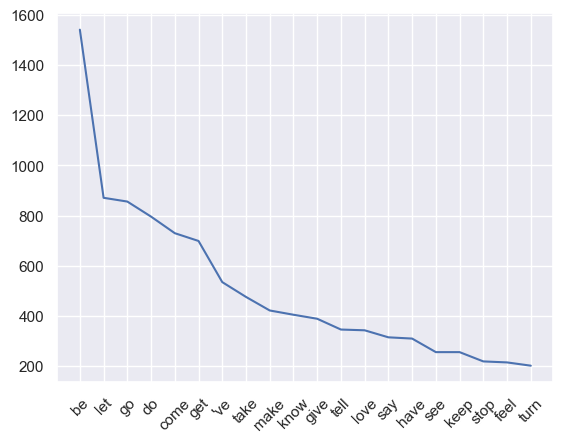

In [141]:
# Only plot top20 verbs
top20_verbs = whcfdist_POStoWord['VB'].most_common(20)
temp_x = []
temp_y = []
for temp_pair in top20_verbs:
    temp_x.append(temp_pair[0])
    temp_y.append(temp_pair[1])
plt.plot(temp_x, temp_y)    
plt.xticks(rotation=45) 

In [142]:
# Word Probabilities
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

chorus
0.05459279422455915


### Word Cloud

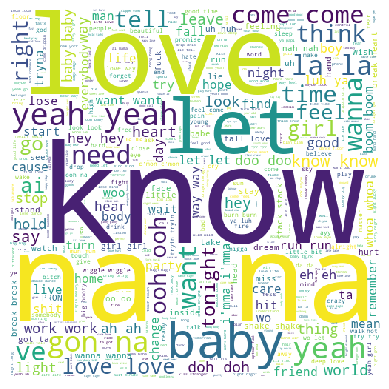

In [144]:
# Word Cloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("song_lyrics_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [161]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [162]:
df_top50 = df.sort_values('pop')[-50:]
df_top50['sentences'] = df_top50['Lyrics'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
df_top50.index = range(len(df_top50) - 1, -1, -1) # Reindex
df_top50.tail()

,Lyrics,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,...,dur,acous,spch,pop,tokenized,word_counts,normalized_tokens,normalized_tokens_count,normalized_pos,sentences
4,"\n\n[Verse 1: Ed Sheeran]\nShe got the mmm, br...",South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,pop,2019,98,62,86,-6,9,...,204,15,8,92.0,"[She, got, the, mmm, brown, eyes, caramel, thi...",646,"[get, mmm, brown, eye, caramel, thigh, long, h...",329,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)...","[[Verse, 1], [Ed, Sheeran], [She, got, the, mm..."
3,\n\n[Verse 1]\nI've been havin' dreams\nJumpin...,Trampoline (with ZAYN),SHAED,electropop,2019,127,46,62,-6,14,...,184,56,3,92.0,"[I, 've, been, havin', dreams, Jumpin, on, a, ...",232,"[ve, have, dream, jumpin, trampoline, flippin,...",118,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)...","[[Verse, 1], [I, 've, been], [havin', dreams, ..."
2,"\n\n[Verse 1]\nI'm going under, and this time,...",Someone You Loved,Lewis Capaldi,pop,2019,110,41,50,-6,11,...,182,75,3,96.0,"[I, 'm, going, under, and, this, time, I, fear...",336,"[m, go, time, fear, save, get, way, drive, cra...",105,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)...","[[Verse, 1], [I, 'm, going, under, and, this, ..."
1,\n\n[Verse 1]\nYou promised the world and I fe...,Lose You To Love Me,Selena Gomez,dance pop,2019,102,34,51,-9,21,...,206,58,4,97.0,"[You, promised, the, world, and, I, fell, for,...",364,"[promise, world, fall, adore, set, fire, fores...",164,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)...","[[Verse, 1], [You, promised, the, world, and, ..."
0,\n\n[Chorus]\nHere's to the ones that we got\n...,Memories,Maroon 5,pop,2019,91,32,76,-7,8,...,189,84,5,99.0,"[Here, 's, to, the, ones, that, we, got, Cheer...",458,"[one, get, cheer, wish, because, drink, bring,...",226,"[(\n\n, _SP), ([, -LRB-), (chorus, NN), (], -R...","[[Chorus], [Here, 's, to, the, ones, that, we,..."


In [163]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [164]:
df_top50['POS_sents'] = df_top50['sentences'].apply(lambda x: tag_sents_pos(x))

In [167]:
# Then we count based on different condition
def count_target(countTarget, df=df_top50):
    targetCounts = {}
    for entry in df['POS_sents']:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != countTarget:
                    continue
                elif ent in targetCounts:
                    targetCounts[ent] += 1
                else:
                    targetCounts[ent] = 1
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedTargets

# 1. NN (noun)
count_target('NN')[:10]

[('m', 222),
 ('love', 112),
 ('baby', 107),
 ('Verse', 70),
 ('way', 62),
 ('time', 55),
 ('heart', 39),
 ('mind', 31),
 ('ve', 28),
 ('body', 26)]

In [168]:
# 2. VB (verbs)
count_target('VB')[:10]

[('be', 138),
 ('love', 88),
 ('let', 80),
 ('go', 77),
 ('do', 63),
 ('get', 58),
 ('know', 43),
 ('give', 40),
 ('stop', 36),
 ('tell', 32)]

In [169]:
# 3. JJ (adjectives)
count_target('JJ')[:10]

[('good', 36),
 ('real', 27),
 ('only', 26),
 ('bad', 24),
 ('new', 24),
 ('right', 18),
 ('crazy', 18),
 ('sorry', 16),
 ('beautiful', 16),
 ('wrong', 15)]

In [170]:
def target_word(NTarget, Word, df=df_top50):
    NResults = set()
    for entry in df['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1,ent2.lower())==(NTarget,Word):
                    NResults.add(ent1)
                else:
                    continue
    return NResults

target_word('JJ', 'time')

{'good', 'next', 'only'}

In [171]:
target_word('VB', 'time')

{'stop'}

In [172]:
target_word('NN', 'time')

{'breath', 'closing', 'fall'}

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [175]:
Bigrams = nltk.collocations.BigramCollocationFinder.from_words(df_top50['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(Bigrams.N))

There are 9096 bigrams in the finder


### Bigram

In [180]:
def bigramScoring(count, wordsTuple, total):
    return count

print(Bigrams.nbest(bigramScoring, 20))

[('doh', 'doh'), ('ooh', 'ooh'), ('doo', 'doo'), ('na', 'na'), ('like', 'like'), ('yeah', 'yeah'), ('m', 'love'), ('let', 'let'), ('love', 'love'), ('love', 'yeah'), ('baby', 'm'), ('uptown', 'funk'), ('m', 'sorry'), ('nah', 'nah'), ('say', 'like'), ('ai', 'get'), ('fuck', 'real'), ('m', 'fuck'), ('yeah', 'love'), ('la', 'la')]


In [181]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
Bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:20]

[(('doh', 'doh'), 1644.9962707734917),
 (('doo', 'doo'), 673.9108893544063),
 (('ooh', 'ooh'), 453.23324382797637),
 (('uptown', 'funk'), 391.30850727653035),
 (('na', 'na'), 379.51691467475183),
 (('fuck', 'real'), 258.3178480335703),
 (('nah', 'nah'), 241.15324629874385),
 (('la', 'la'), 222.90630033862936),
 (('dusk', 'till'), 209.88628633099293),
 (('till', 'dawn'), 209.88628633099293),
 (('believe', 'watch'), 200.9941386296573),
 (('get', 'ta'), 187.7148015757637),
 (('south', 'border'), 184.51783515728738),
 (('check', 'nail'), 176.06963945536668),
 (('toss', 'check'), 176.06963945536668),
 (('hair', 'toss'), 160.20605309584138),
 (('good', 'hell'), 159.81928291236105),
 (('memory', 'bring'), 156.0561651456793),
 (('half', 'past'), 153.64434353510654),
 (('ai', 'get'), 150.63917669491403)]

### Trigram

In [182]:
# trigram
trigram_measures = nltk.collocations.TrigramAssocMeasures()
Trigrams = nltk.collocations.TrigramCollocationFinder.from_words(df_top50['normalized_tokens'].sum())
Trigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('doh', 'doh', 'doh'), 13.369337154741547),
 (('doo', 'doo', 'doo'), 7.549434137365769),
 (('ooh', 'ooh', 'ooh'), 7.277714387531464),
 (('na', 'na', 'na'), 5.289544269493492),
 (('m', 'fuck', 'real'), 4.897968240162686),
 (('love', 'yeah', 'love'), 4.647864899482258),
 (('la', 'la', 'la'), 4.582442098597049),
 (('say', 'like', 'like'), 4.577311260452095),
 (('yeah', 'yeah', 'yeah'), 4.338338800573287),
 (('ai', 'get', 'old'), 4.122705718578986),
 (('ooh', 'na', 'na'), 4.1201161136935145),
 (('let', 'let', 'let'), 4.115893289775363),
 (('love', 'love', 'yeah'), 4.074700068239203),
 (('dusk', 'till', 'dawn'), 3.8729714094901686),
 (('feelin', 'good', 'hell'), 3.8728712814972526),
 (('m', 'love', 'body'), 3.8639638315849534),
 (('funk', 'uptown', 'funk'), 3.7415786043983172),
 (('uptown', 'funk', 'uptown'), 3.7415786043983172),
 (('feelin', 'feelin', 'good'), 3.741400970152635),
 (('get', 'old', 'ai'), 3.741216710680318)]

### Ngrams, n=4

In [193]:
# ngrams, n=4
Ngrams = nltk.ngrams(df_top50['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]

In [194]:
sorted(Filtered.items(), key=lambda kv:(kv[1], kv[0]), reverse=True)[:20]

[(('doh', 'doh', 'doh', 'doh'), 158),
 (('doo', 'doo', 'doo', 'doo'), 54),
 (('ooh', 'ooh', 'ooh', 'ooh'), 42),
 (('la', 'la', 'la', 'la'), 20),
 (('na', 'na', 'na', 'na'), 17),
 (('love', 'love', 'yeah', 'love'), 17),
 (('uptown', 'funk', 'uptown', 'funk'), 14),
 (('old', 'ai', 'get', 'old'), 14),
 (('get', 'old', 'ai', 'get'), 14),
 (('feelin', 'feelin', 'good', 'hell'), 14),
 (('baby', 'feelin', 'feelin', 'good'), 14),
 (('ai', 'get', 'old', 'ai'), 14),
 (('yeah', 'love', 'love', 'yeah'), 13),
 (('love', 'yeah', 'love', 'love'), 13),
 (('havana', 'ooh', 'na', 'na'), 13),
 (('touch', 'feel', 'm', 'fuck'), 12),
 (('toss', 'check', 'nail', 'baby'), 12),
 (('time', 'love', 'touch', 'feel'), 12),
 (('real', 'm', 'fuck', 'real'), 12),
 (('past', 'time', 'love', 'touch'), 12)]

As expected, we would find that for n-grams (n=2,3,4), most words are modal particle which are frequently used in songs. Apart these, "fuck real", "good hell", "funk uptown", "get old", "feel good" are all interesting observations from the above observations.

In [201]:
def getKey(item):
    return item[1]

In [203]:
# If we would like to observe n-grams for certain specific words, we just use the following:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_all = Bigrams.score_ngrams(bigram_measures.likelihood_ratio)

bigram_key = []
keyword = 'love'
for bigram in bigram_all:
    if keyword in bigram[0]:
        bigram_key.append(bigram)

sorted(bigram_key, key=getKey, reverse=True)[:10]

[(('love', 'body'), 102.17139464013172),
 (('love', 'touch'), 65.35524576981904),
 (('love', 'yeah'), 55.5685458096143),
 (('love', 'possibility'), 48.35609791207553),
 (('fallin', 'love'), 42.39126917934549),
 (('love', 'ceiling'), 41.42781303033065),
 (('love', 'shape'), 41.42781303033065),
 (('love', 'love'), 37.45696225447737),
 (('let', 'love'), 36.30969604884518),
 (('something', 'love'), 32.35277719601865)]

In [205]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
nltk.collocations.TrigramCollocationFinder.from_words(df_top50['normalized_tokens'].sum())
trigram_all = Trigrams.score_ngrams(trigram_measures.student_t)

trigram_key = []
keyword = 'love'
for trigram in trigram_all:
    if keyword in trigram[0]:
        trigram_key.append(trigram)

sorted(trigram_key, key=getKey, reverse=True)[:10]

[(('love', 'yeah', 'love'), 4.647864899482258),
 (('love', 'love', 'yeah'), 4.074700068239203),
 (('m', 'love', 'body'), 3.8639638315849534),
 (('yeah', 'love', 'love'), 3.5501974028685725),
 (('past', 'time', 'love'), 3.463177677083179),
 (('time', 'love', 'touch'), 3.463045685932525),
 (('love', 'touch', 'feel'), 3.462623314250434),
 (('let', 'love', 'let'), 3.445597471132653),
 (('love', 'let', 'love'), 3.424214904726757),
 (('love', 'way', 'lie'), 3.3146396026016633)]

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [206]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [209]:
df_top50['classified_sents'] = df_top50['sentences'].apply(lambda x: tag_sents_ner(x))
df_top50['classified_sents'][:10]

49    [[(Intro Payback, ORG)], [], [], [], [], [], [...
48    [[(1, CARDINAL)], [(Hurry, PERSON)], [], [], [...
47    [[], [], [], [], [], [], [], [], [], [], [], [...
46    [[], [], [], [(Sellin, GPE), (Smoke, NORP)], [...
45    [[(Chorus Rihanna, PERSON)], [], [], [], [], [...
44    [[(Intro Bruno, PERSON), (Mars Doh, PRODUCT)],...
43    [[(1, CARDINAL)], [], [(Fighter, ORG)], [], []...
42    [[], [], [], [], [], [], [(Picket, PERSON)], [...
41    [[(1, CARDINAL)], [], [], [], [], [], [], [], ...
40    [[(Benny Blanco, PERSON)], [], [], [], [], [],...
Name: classified_sents, dtype: object

In [210]:
# Counting
entityCounts = {}
for entry in df_top50['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Chorus', 85),
 ('1', 24),
 ('tonight', 20),
 ('Feelin', 19),
 ('Outro', 15),
 ('Nick Jonas', 15),
 ('Joe Jonas', 14),
 ('Post Chorus', 12),
 ('Baby', 12),
 ('One', 12)]

In [211]:
# Non Objects
nonObjCounts = {}
for entry in df_top50['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Chorus', 84),
 ('1', 24),
 ('tonight', 20),
 ('Feelin', 19),
 ('Outro', 15),
 ('Nick Jonas', 15),
 ('Joe Jonas', 14),
 ('Post Chorus', 12),
 ('One', 12),
 ('Woo', 11)]

In [213]:
OrgCounts = {}
for entry in df_top50['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                if ent not in OrgCounts:
                    OrgCounts[ent] = 0
                OrgCounts[ent] += 1

sortedOrg = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrg[:10]               

[('Baby', 9),
 ('Fresh', 4),
 ('Better', 3),
 ('Single', 3),
 ('Chorus Gold', 3),
 ('Tryna', 3),
 ('Post Chorus Hailee Steinfeld', 2),
 ('Bridge For', 2),
 ('Post Chorus ZAYN Sia', 2),
 ('Cadillac', 2)]

## <span style="color:red">*Exercise 7*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [226]:
from spacy import displacy
from spacy.symbols import nsubj, VERB

### Dependency Parsing

In [234]:
# Dependency parsing
doc = nlp(" ".join(df_top50['sentences'][0][1]))
displacy.render(doc, style='dep')

In [235]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

the ones ones pobj to
we we nsubj got
Cheers Cheers dobj got
the wish wish pobj to
you you nsubj were
you you nsubj 're


In [236]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Here advmod 's AUX []
's ROOT 's AUX [Here, to]
to prep 's AUX [ones]
the det ones NOUN []
ones pobj to ADP [the, got]
that mark got VERB []
we nsubj got VERB []
got relcl ones NOUN [that, we, Cheers, to]
Cheers dobj got VERB []
to prep got VERB [wish]
the det wish NOUN []
wish pobj to ADP [the, were]
you nsubj were AUX []
were relcl wish NOUN [you, here]
here advmod were AUX []
but cc 're AUX []
you nsubj 're AUX []
're ROOT 're AUX [but, you, not, 'Cause]
not neg 're AUX []
'Cause punct 're AUX []


In [237]:
# Select the verb from the lyrics
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{got}


In [238]:
#local tree
print(doc[7])
print([token.text for token in doc[7].lefts]) 
print([token.text for token in doc[7].rights])
print(doc[7].n_lefts)
print(doc[7].n_rights)

got
['that', 'we']
['Cheers', 'to']
2
2


In [243]:
root = [token for token in doc if token.head == token][1]
print(root)
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

're
but cc 0 0 ["'re"]


### Information Extraction

In [247]:
# Information Extraction
ls_love = []
for index, row in df_top50.iterrows():
    text = ' '.join(row['tokenized'])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'love':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0 or object_ is not 0:
                ls_love.append((subject, object_))

dict_love = {}
for love in ls_love:
    if love not in dict_love:
        dict_love[love] = 0
    dict_love[love] += 1

sorted(dict_love.items(), key = lambda x : x[1], reverse = True)

[(('I', 0), 38),
 ((0, 'you'), 21),
 ((0, 'yourself'), 16),
 ((0, 'love'), 16),
 ((0, 'it'), 15),
 ((0, 'me'), 14),
 (('me', 0), 13),
 ((0, 'way'), 11),
 (('Someone', 0), 8),
 (('he', 0), 5),
 (('someone', 0), 3),
 ((0, 'baby'), 3),
 (('You', 0), 2),
 ((0, 'her'), 1),
 ((0, 'somebody'), 1),
 (('you', 0), 1),
 ((0, 'ya'), 1),
 ((0, 'lips'), 1)]

As is shown in the above dictionary, it seems that "I love you" appears much more frequent than other terms, which is one of the major trend in top 10 lyrics.

## <span style="color:red">*Exercise 8*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

Similarly, we construct a dataset which from the least 50 songs from the database and compared them with the top50s

In [248]:
df_last50 = df.sort_values('pop')[:50]
df_last50.head()

,Lyrics,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,tokenized,word_counts,normalized_tokens,normalized_tokens_count,normalized_pos
39,"\n\n[Verse 1]\nHello, it's me\nI was wondering...",Hello,Martin Solveig,big room,2010,128,98,67,-3,10,45,191,1,3,0.0,"[Hello, it, 's, me, I, was, wondering, if, aft...",383,"[hello, wonder, year, like, meet, time, suppos...",145,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)..."
180,\n\n[Verse 1]\nSaid all I want from you\nIs to...,Not a Bad Thing,Justin Timberlake,dance pop,2014,86,73,59,-6,38,46,266,27,6,0.0,"[Said, all, I, want, from, you, Is, to, see, y...",498,"[say, want, tomorrow, tomorrow, maybe, let, bo...",181,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)..."
306,\n\n[Produced by Greg Kurstin]\n\n[Verse 1]\nI...,Million Years Ago,Adele,british soul,2016,0,0,0,-60,0,0,227,0,0,0.0,"[I, only, wanted, to, have, fun, Learning, to,...",302,"[want, fun, learn, fly, learn, run, let, heart...",102,"[(\n\n, _SP), ([, -LRB-), (produced, VBN), (by..."
413,"\n\n[Pre-Hook]\nOh no, we don't play with sill...",Muny - Album Version (Edited),Nicki Minaj,dance pop,2011,98,72,80,-5,19,53,227,56,33,7.0,"[Oh, no, we, do, n't, play, with, silly, girls...",683,"[play, silly, girl, know, material, girl, muny...",418,"[(\n\n, _SP), ([, -LRB-), (pre, JJ), (-, JJ), ..."
254,"\n\n[Hook]\nI do it for the thrill, even if it...",Dangerous,Jennifer Hudson,dance pop,2015,109,53,90,-5,8,65,255,0,5,18.0,"[I, do, it, for, the, thrill, even, if, it, ki...",392,"[thrill, kill, dangerous, feel, dangerous, thr...",151,"[(\n\n, _SP), ([, -LRB-), (hook, NN), (], -RRB..."


In [249]:
df_top50.head()

,Lyrics,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,...,spch,pop,tokenized,word_counts,normalized_tokens,normalized_tokens_count,normalized_pos,sentences,POS_sents,classified_sents
49,"\n\n[Intro]\nPayback is a bad bitch\nAnd baby,...",Sorry Not Sorry,Demi Lovato,dance pop,2018,144,64,71,-7,26,...,23,81.0,"[Payback, is, a, bad, bitch, And, baby, I, 'm,...",534,"[payback, bad, bitch, baby, m, baddest, m, bad...",268,"[(\n\n, _SP), ([, -LRB-), (intro, NNP), (], -R...","[[Intro], [Payback, is, a, bad, bitch, And, ba...","[[(Intro, NNP), (Payback, NNP), (is, VBZ), (a,...","[[(Intro Payback, ORG)], [], [], [], [], [], [..."
48,"\n\n[Verse 1]\nCrashing, hit a wall\nRight now...",Don't Let Me Down,The Chainsmokers,electropop,2016,160,87,53,-5,14,...,17,81.0,"[Crashing, hit, a, wall, Right, now, I, need, ...",417,"[crash, hit, wall, right, need, miracle, hurry...",116,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)...","[[Verse, 1], [Crashing, hit, a, wall], [Right,...","[[(Verse, NN), (1, CD), (Crashing, VBG), (hit,...","[[(1, CARDINAL)], [(Hurry, PERSON)], [], [], [..."
47,"\n\n[Verse 1: Dua Lipa]\nFalling into you, bab...",Electricity (with Dua Lipa),Silk City,edm,2018,118,67,59,-6,34,...,5,82.0,"[Falling, into, you, baby, Even, electricity, ...",567,"[fall, baby, electricity, compare, feel, m, oo...",219,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)...","[[Verse, 1], [Dua, Lipa], [Falling, into, you,...","[[(Verse, NN), (1, CD)], [(Dua, NNP), (Lipa, N...","[[], [], [], [], [], [], [], [], [], [], [], [..."
46,\n\n[Verse 1: Justin Bieber]\nI used to believ...,Let Me Love You,DJ Snake,electronic trap,2017,100,72,65,-5,14,...,3,82.0,"[I, used, to, believe, We, were, burnin, on, t...",309,"[believe, burnin, edge, something, beautiful, ...",131,"[(\n\n, _SP), ([, -LRB-), (verse, NN), (1, CD)...","[[Verse, 1, Justin, Bieber], [I, used, to, bel...","[[(Verse, NN), (1, CD), (Justin, NNP), (Bieber...","[[], [], [], [(Sellin, GPE), (Smoke, NORP)], [..."
45,\n\n[Chorus: Rihanna]\nJust gonna stand there ...,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,...,23,82.0,"[Just, gon, na, stand, there, and, watch, me, ...",801,"[gon, na, stand, watch, burn, right, like, way...",314,"[(\n\n, _SP), ([, -LRB-), (chorus, NN), (:, :)...","[[Chorus, Rihanna], [Just, gon, na, stand, the...","[[(Chorus, NNP), (Rihanna, NNP), (Just, RB), (...","[[(Chorus Rihanna, PERSON)], [], [], [], [], [..."


### Overlap Words

In [250]:
top_words = set(df_top50['normalized_tokens'].sum())
last_words = set(df_last50['normalized_tokens'].sum())

overlapWords = top_words & last_words
overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [255]:
sorted(overlapWordsDict.items(), key = lambda x : x[1], reverse = True)[0]

('piece', 608)

In [256]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

topProbArray = makeProbsArray(df_top50['normalized_tokens'], overlapWordsDict)
lastProbArray = makeProbsArray(df_last50['normalized_tokens'], overlapWordsDict)
lastProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

### KL Divergence

In [258]:
top_divergence = scipy.stats.entropy(topProbArray, lastProbArray)
last_divergence =scipy.stats.entropy(lastProbArray, topProbArray)
print(top_divergence)
print(last_divergence)

0.41542732715741554
0.44431504713107384


In [260]:
kl_Divergence = scipy.special.kl_div(topProbArray, lastProbArray)
kl_df = pd.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = kl_Divergence
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
140,nah,0.016322
225,love,0.012021
152,na,0.011923
159,feelin,0.011883
539,ya,0.011519
135,ayy,0.009452
508,break,0.008594
378,yeah,0.008066
294,run,0.007670
219,m,0.007430


### Some useful functions

In [267]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [287]:
corpora = []
for index, row in df_top50.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['tokenized'])

for index, row in df_last50.iterrows():
    if len(corpora) > 21:
        break
    corpora.append(row['tokenized'])

In [288]:
len(corpora)

22

In [289]:
fileids = list(df_top50['title'])[0:11] 
fileids += list(df_last50['title'])[0:11]

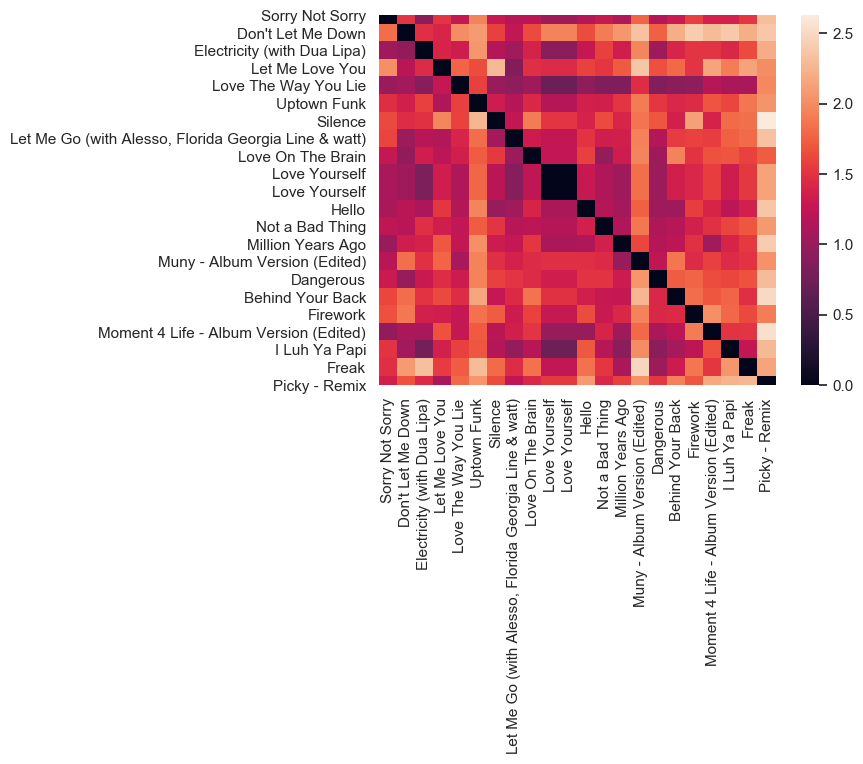

In [290]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

### $\chi^2$ Divergence

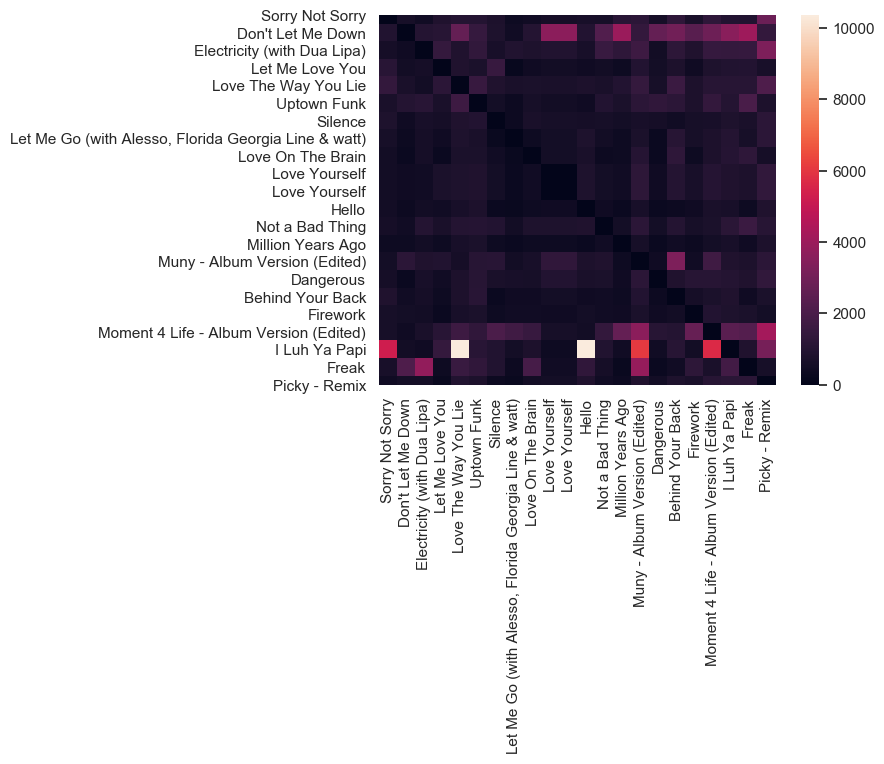

In [293]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

### KS Distance

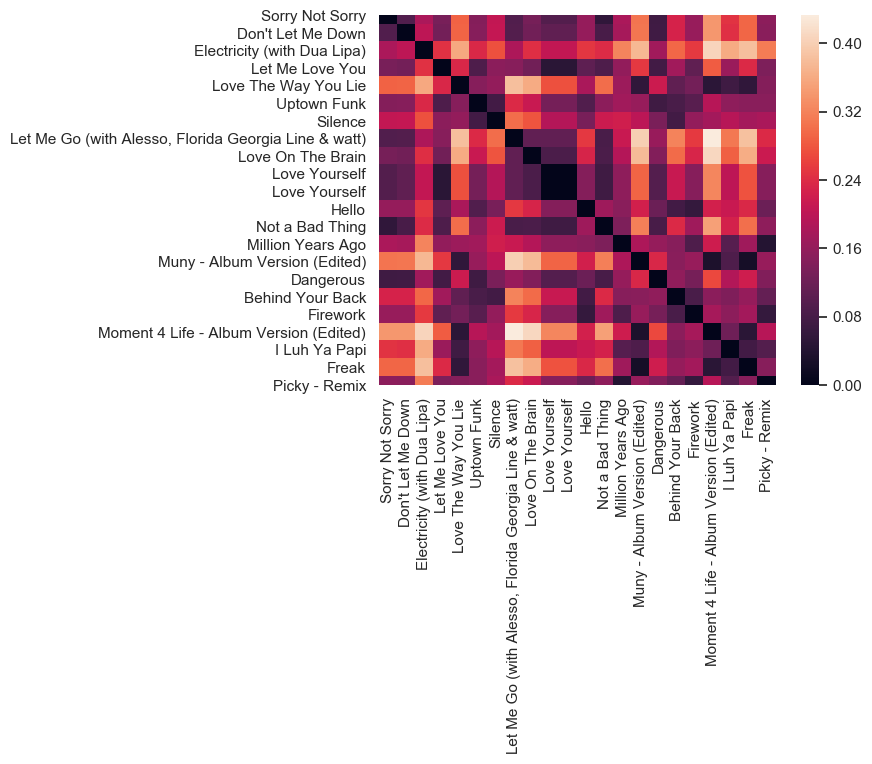

In [294]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

### Wasserstein Distance

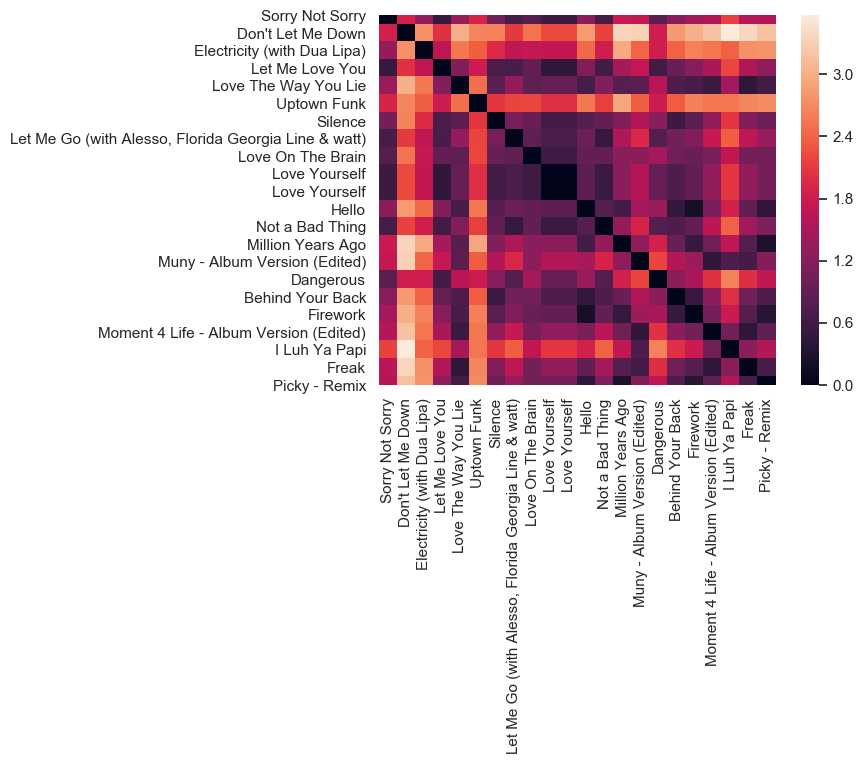

In [295]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

### Multidimensional Scaling

C:\Users\qmun\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


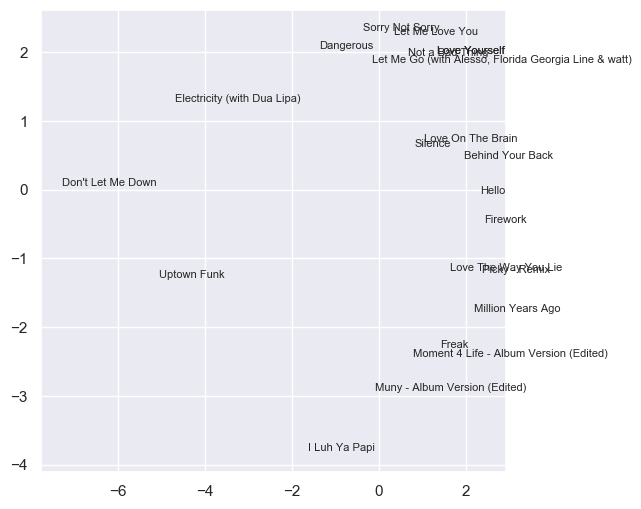

In [301]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]), size=8)

As is shown in the picture, KL divergence can capture difference much bettwe than $\chi^2$ divergence. KL seems to have better clarification that the other. KS and Wasserstein performs similar to each other.